In [3]:
import sys
sys.path.append('../') 


%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [4]:
aggregate_by_state = False
outcome_type = 'deaths'

# Dataset Creation

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
important_vars = load_data.important_keys(df)

loaded and merged COVID-19 cases/deaths data successfully


In [6]:
from datetime import date

In [7]:
first_date = date(2020,1,22)
first_ordinal = first_date.toordinal()

 Create:

df['days_since_order'] which is the number of days since the shelter in place order has gone into effect

df['week_since_order'] which is if it's been a week since the order

df['two_weeks_since_order'] which is if it's been two weeks since the order

In [8]:
days_since_order = []
past_one_week = []
past_two_weeks = []
shelter_in_place_orders = list(df['stay at home'])
nan_counties = []
total_num_days = len(list(df['deaths'])[0])
for j,order in enumerate(shelter_in_place_orders):
    county_days_since_orders = []
    county_one_week = []
    county_two_week = []
    if np.isnan(order):
        nan_counties.append(list(df['CountyName'])[j]+ ' '+list(df['StateName'])[j])
        order = 1e10
    for i in range(total_num_days):
        current_date = first_ordinal+i
        county_days_since_orders.append(max(current_date-order,0))
        county_one_week.append(int(current_date > order + 7))
        county_two_week.append(int(current_date > order + 14))

    days_since_order.append(county_days_since_orders)
    past_one_week.append(county_one_week)
    past_two_weeks.append(county_two_week)

df['days_since_order'] = days_since_order
df['week_since_order'] = past_one_week
df['two_weeks_since_order'] = past_two_weeks


Find neighboring county deaths/cases

In [9]:
neighboring_counties_df = pd.read_csv('../data/county_level/raw/county_ids/county_adjacency2010.csv')

In [10]:
df['countyFIPS'] = [int(v) for v in list(df['countyFIPS'])]

In [11]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
number_of_days = len(list(df['deaths'])[0])
for fips in county_fips:
    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    

    sum_neighboring_county_deaths = np.zeros(number_of_days)
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(number_of_days)
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)



In [12]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


Find the number of new deaths (smoothed)

In [13]:
new_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:
    county_new_deaths = []
    for i in range(len(list(county_deaths))):
        if i == 0: 
            county_new_deaths.append(list(county_deaths)[0])
        else:
            county_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-1])

    smoothed_county_new_deaths = []
    window = 5
    for i in range(len(county_new_deaths)):
        start = max(i-window,0)
        end = min(i+window,len(county_new_deaths)-1)
        smoothed_county_new_deaths.append(sum(county_new_deaths[start:end])/len(county_new_deaths[start:end]))
        
    new_deaths.append(np.array(smoothed_county_new_deaths))
df['new_deaths'] = new_deaths

In [205]:
def k_day_growth(k):
    new_deaths = []
    deaths = list(df['deaths'])
    for county_deaths in deaths:
        county_new_deaths = []
        for i in range(len(list(county_deaths))):
            if i < k: 
                county_new_deaths.append(list(county_deaths)[0])
            else:
                county_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-k])

        new_deaths.append(county_new_deaths)
    df['deaths_'+str(k)+'_day_growth'] = new_deaths
    

In [206]:
k_day_growth(3)
k_day_growth(5)
k_day_growth(7)

17

Find number of new deaths per capita * 100k

In [14]:
new_deaths = []
per_cap_deaths = []
deaths = list(df['deaths'])
pop = list(df['PopulationEstimate2018'])
for county_ind,county_deaths in enumerate(deaths):
    county_per_cap_deaths = []
    for i in range(len(list(county_deaths))):
        county_per_cap_deaths.append(list(county_deaths)[i]/pop[county_ind]*100000)
        
    per_cap_deaths.append(np.array(county_per_cap_deaths))
    
df['deaths_per_cap'] = per_cap_deaths

Find number of new cases per capita * 100k


In [15]:
new_deaths = []
per_cap_deaths = []
deaths = list(df['cases'])
pop = list(df['PopulationEstimate2018'])
for county_ind,county_deaths in enumerate(deaths):
    county_per_cap_deaths = []
    for i in range(len(list(county_deaths))):
        county_per_cap_deaths.append(list(county_deaths)[i]/pop[county_ind]*100000)
        
    per_cap_deaths.append(np.array(county_per_cap_deaths))
    
df['cases_per_cap'] = per_cap_deaths

In [16]:
max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-1])
    
df['max_death_per_cap'] = max_deaths_per_cap

per_cap_deaths = list(df['deaths_per_cap'])
max_deaths_per_cap = []

for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14])
    
df['max_death_per_cap_minus_2_weeks'] = max_deaths_per_cap

max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-19])
    
df['max_death_per_cap_minus_2_weeks_5_day_growth'] = max_deaths_per_cap


max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-21])
    
df['max_death_per_cap_minus_2_weeks_7_day_growth'] = max_deaths_per_cap



max_deaths_per_cap = []
per_cap_deaths = list(df['deaths_per_cap'])
for county_per_cap_deaths in per_cap_deaths:    
    max_deaths_per_cap.append( county_per_cap_deaths[-14]-county_per_cap_deaths[-17])
    
df['max_death_per_cap_minus_2_weeks_3_day_growth'] = max_deaths_per_cap



max_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:    
    max_deaths.append( county_deaths[-14])
    
df['max_deaths_minus_two_weeks'] = max_deaths


max_deaths = []
deaths = list(df['cases'])
for county_deaths in deaths:    
    max_deaths.append( county_deaths[-14])
    
df['max_cases_minus_two_weeks'] = max_deaths

Only include rural counties

In [17]:
df = df.loc[df['Rural-UrbanContinuumCode2013'] > 3]

## Find neighbors

In [168]:
# Features for finding neighbors
very_important_vars = [
#     'PopulationDensityperSqMile2010',
#     'PopulationEstimate2018',
#     'Rural-UrbanContinuumCode2013',
#      'MedianAge2010',
#     'stay at home',
#
#         '#ICU_beds',

    'max_death_per_cap_minus_2_weeks_5_day_growth',
      'max_death_per_cap_minus_2_weeks_3_day_growth',
          'max_death_per_cap_minus_2_weeks_7_day_growth',
#         'max_death_per_cap_minus_2_weeks',
#         'max_deaths_minus_two_weeks',
#         'max_cases_minus_two_weeks'

]

static_features = [ 
    'PopulationDensityperSqMile2010',
    'PopulationEstimate2018',
    'Rural-UrbanContinuumCode2013',
     'MedianAge2010',
#     'stay at home'
]
very_important_vars = static_features

In [169]:
very_important_vars = [
#     'PopulationDensityperSqMile2010',
#     'PopulationEstimate2018',
#     'Rural-UrbanContinuumCode2013',
#      'MedianAge2010',
#     'stay at home',
#
#         '#ICU_beds',

    'max_death_per_cap_minus_2_weeks_5_day_growth',
      'max_death_per_cap_minus_2_weeks_3_day_growth',
          'max_death_per_cap_minus_2_weeks_7_day_growth',
#         'max_death_per_cap_minus_2_weeks',
#         'max_deaths_minus_two_weeks',
#         'max_cases_minus_two_weeks'

]

In [191]:
df['deaths_per_cap']

304     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1214    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
480     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1153    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
508     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
11      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: deaths_per_cap, Length: 1975, dtype: object

In [ ]:
static_features=[]

In [210]:
dynamic_features = ['deaths_per_cap','deaths','new_deaths','deaths_3_day_growth','deaths_5_day_growth','deaths_7_day_growth']


sort by deaths two weeks ago, scale (and potentially do PCA) 

In [198]:
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from sklearn.decomposition import PCA

# df = df.sort_values(['max_death_per_cap_minus_2_weeks','countyFIPS'], ascending=False)
df = df.sort_values(['max_deaths_minus_two_weeks','countyFIPS'], ascending=False)


covariates = df[very_important_vars]

covariates_clean = covariates.dropna(1)
 

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_covs = covariates_clean.select_dtypes(include=numerics)


scaled_covariates = StandardScaler().fit_transform(numeric_covs.values)

pca = PCA(n_components=max(1,int(len(very_important_vars)/3)))
principle_components = pca.fit_transform(scaled_covariates)
# principle_components = scaled_covariates


In [194]:
def generate_features(static_features,dynamic_features,time_index):
    static_covariates = df[static_features].values
    all_dynamic_covariates = df[dynamic_features].values
    dynamic_covariates_unprocessed = list(df[dynamic_features].values)
    dynamic_covariates = []
    for county in dynamic_covariates_unprocessed:
        county_proc = []
        for feature in list(county):
            county_proc.append(list(feature))
        dynamic_covariates.append(county_proc)
        
    dynamic_covariates = np.array(dynamic_covariates)[:,:,time_index]
        
    covariates = np.concatenate([static_covariates,dynamic_covariates],axis=1)
    scaler = StandardScaler()
    scaled_covariates = scaler.fit_transform(covariates)
    pca = PCA(n_components=max(1,int(scaled_covariates.shape[1]/3)))
    principle_components = pca.fit_transform(scaled_covariates)
    return principle_components, scaler, pca


    
    

    
    
    

In [195]:
def find_top_k_time_dynamic(county_index,time_query,df,num_neighbors,tol=.1):
    death_per_cap = list(df['deaths_per_cap'])
    query_val = death_per_cap[county_index][time_query]
    possible_indices = []
    time_indices = []
    query_dists = []
    for i in range(len(death_per_cap)):
        if i != county_index:
            dists = np.abs(death_per_cap[i][:time_query-14+1]-query_val)
            best_match = death_per_cap[i][np.argmin(dists)]
            time_index = np.argmin(dists)
            assert time_index < len(death_per_cap[i])-time_query, time_index
            if best_match < query_val*(1+tol) and best_match > query_val*(1-tol):
                possible_indices.append(i)
                time_indices.append(time_index)
                query_dists.append(np.abs(best_match-query_val))
    index_to_time_dict = {k:v for (k,v) in zip(possible_indices,time_indices)}
    
    
    neighbor_features, scaler, pca = generate_features(static_features,dynamic_features,time_query-14)
    county_static_features = df.iloc[county_index][static_features]
    county_dynamic_featurees = np.vstack(list(df.iloc[county_index][dynamic_features]))[:,time_query]
    county_features = np.concatenate([county_static_features,county_dynamic_featurees])
    transformed_county_features = pca.transform(scaler.transform(county_features.reshape(1, -1)))
    
    most_similar_neighbors, distances = find_top_k_matches(transformed_county_features[0],neighbor_features,
                                                          len(df)) 


    final_matches = []
    final_times = []
    final_distances = []

    for i in range(len(most_similar_neighbors)):
        if most_similar_neighbors[i] in possible_indices:
            final_matches.append(most_similar_neighbors[i])
            final_distances.append(distances[i])
            final_times.append(index_to_time_dict[most_similar_neighbors[i]])
            if len(final_matches) == num_neighbors:
                break
    final_matches = [county_index] + final_matches
    final_times = [len(dists)-1] + final_times
    final_distances = [0] + final_distances

    return final_matches, final_times, final_distances
            

    
        
    
    
    

In [51]:
outcome_type = 'deaths_per_cap'

# outcome_type = 'cases_per_cap'
# outcome_type = 'deaths'

In [52]:
# outcome_type = 'deaths'
import fit_and_predict
advanced_model = {'model_type':'advanced_shared_model'}
linear = {'model_type':'linear'}
d = 14
df = fit_and_predict.fit_and_predict_ensemble(df, 
                                              target_day=np.array(range(1, d+1)),
                                              mode='eval_mode',
                                              outcome=outcome_type,
                                              methods=[ 
                                                  advanced_model,
                                                      linear
                                                     ],
                                              output_key='predicted_al',
                                              verbose=True
                                             )



KeyboardInterrupt: 

# 

In [43]:
# df['predicted_al']

### Graph Visualizations

In [44]:
outcome_type = 'deaths_per_cap'

# outcome_type = 'cases_per_cap'
# outcome_type = 'deaths'

In [179]:
def plot_dynamic_matched_counties(df,indices,time_dif = False, plot_preds = False, weighted = False):
    """
    Plots model predictions   vs actual
    row: dataframe row
    window: autoregressive window size
    """
    index = indices[0]
    
    outcomes = list(df[outcome_type])
    counties = list(df['CountyName'])
    states = list(df['StateName'])


    county_indices, time_indices, distances = find_top_k_time_dynamic(index,-14,df,5,tol=.1)
    if len(county_indices) == 1:
        print('no match found for county: '+ counties[county_indices[0]])
        return None, None

    for i in range(len(county_indices)):

        
        county_vals = outcomes[county_indices[i]][time_indices[i]:]
        if i == 0:
            county_vals = outcomes[county_indices[i]][time_indices[i]:]

            sns.lineplot(list(range(len(county_vals))),county_vals, label=counties[county_indices[i]]+' '+states[county_indices[i]],linewidth=4.0)
        else:
            county_vals = outcomes[county_indices[i]][time_indices[i]-14:]

     
            sns.lineplot(list(range(len(county_vals))),county_vals, label=counties[county_indices[i]]+' '+states[county_indices[i]])


#     avg_neighbors = np.zeros(len(outcomes[county_indices[0]][time_indices[0]-14:]))
    avg_neighbors = np.zeros(28)

    denom = 0
    for i in range(1,len(county_indices)):
        county_vals = outcomes[county_indices[i]][time_indices[i]-14:]
        if weighted:
            avg_neighbors += 1/(distances[i])*county_vals[:len(avg_neighbors)]
            denom += 1/(distances[i])
        else:
            avg_neighbors += county_vals[:len(avg_neighbors)]
    
    if weighted:
        avg_neighbors = avg_neighbors/denom
    else:
        avg_neighbors = avg_neighbors/(len(county_indices)-1)
    
    sns.lineplot(list(range(len(avg_neighbors))),avg_neighbors, label='avg neighbor',linewidth=4.0)
    

    if plot_preds:
         
        county_vals = outcomes[county_indices[0]][time_indices[0]:]
        preds = list(df['predicted_al'])[county_indices[0]]

        sns.scatterplot(list(range(len(county_vals)))[-len(preds):],preds,label='pred')

        
    

    plt.ylabel(outcome_type)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()
    

    
    truth = outcomes[county_indices[0]][time_indices[0]:]
    avg_diff = 0
    for i in range(len(avg_neighbors)-14):
        avg_diff += np.abs(avg_neighbors[-i]-truth[-i])
        
    pred_difs = 0
        
    if plot_preds:
        for t in range(1,15):
             pred_difs += np.abs(preds[-t] - outcomes[indices[0]][-t])
    if not plot_preds:
        pred_difs = 0
    total_difs = avg_diff
    return total_difs, pred_difs
             

In [180]:
from collections import Counter

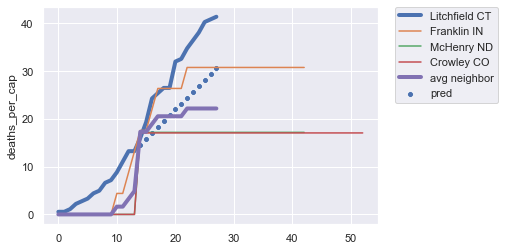

<Figure size 3000x2000 with 0 Axes>

no match found for county: Franklin
no match found for county: Mitchell


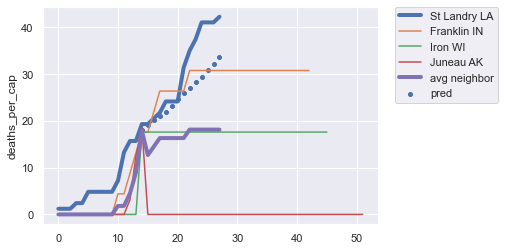

<Figure size 3000x2000 with 0 Axes>

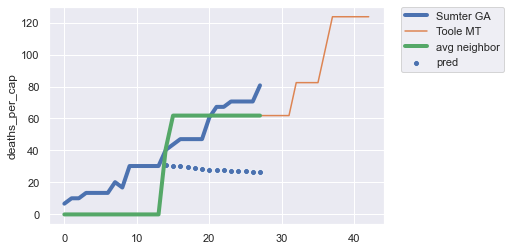

<Figure size 3000x2000 with 0 Axes>

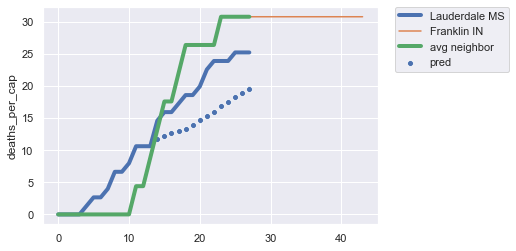

<Figure size 3000x2000 with 0 Axes>

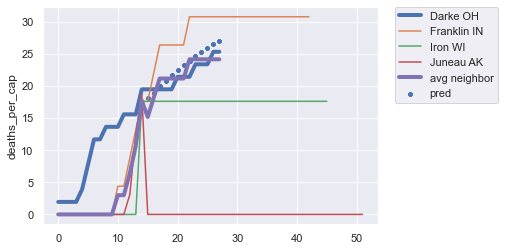

<Figure size 3000x2000 with 0 Axes>

no match found for county: Decatur
no match found for county: Columbia


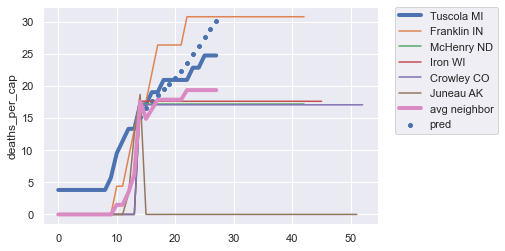

<Figure size 3000x2000 with 0 Axes>

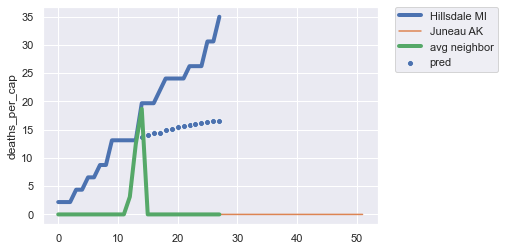

<Figure size 3000x2000 with 0 Axes>

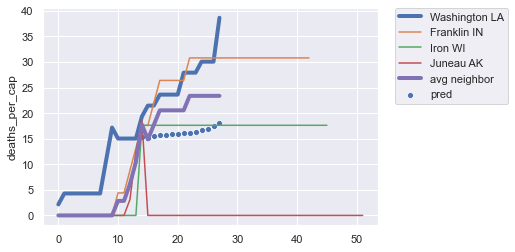

<Figure size 3000x2000 with 0 Axes>

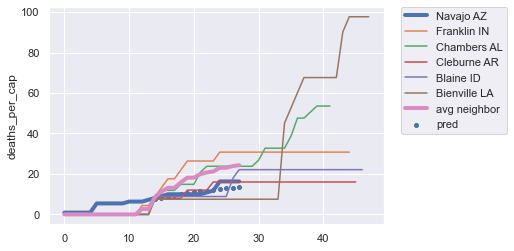

<Figure size 3000x2000 with 0 Axes>

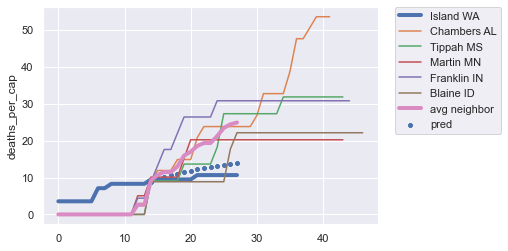

<Figure size 3000x2000 with 0 Axes>

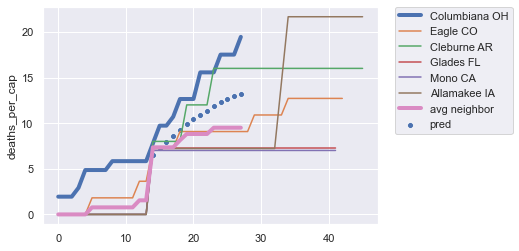

<Figure size 3000x2000 with 0 Axes>

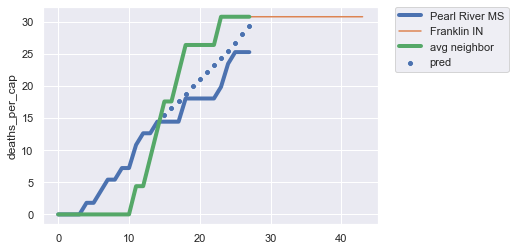

<Figure size 3000x2000 with 0 Axes>

no match found for county: Allen


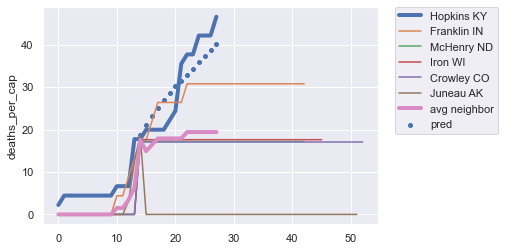

<Figure size 3000x2000 with 0 Axes>

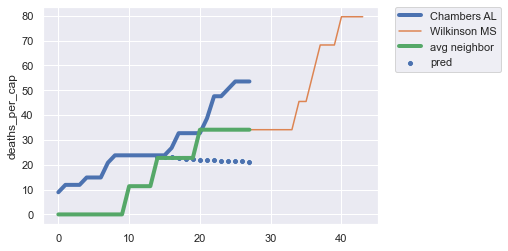

<Figure size 3000x2000 with 0 Axes>

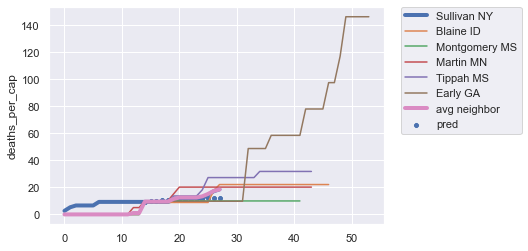

<Figure size 3000x2000 with 0 Axes>

no match found for county: Lawrence
no match found for county: Franklin


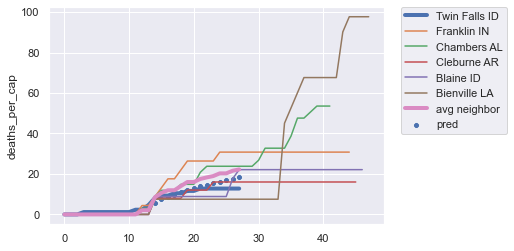

<Figure size 3000x2000 with 0 Axes>

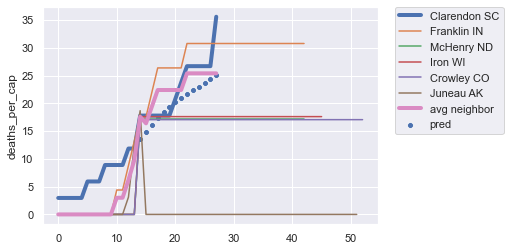

<Figure size 3000x2000 with 0 Axes>

no match found for county: Tippah


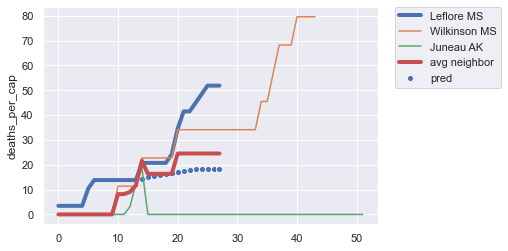

<Figure size 3000x2000 with 0 Axes>

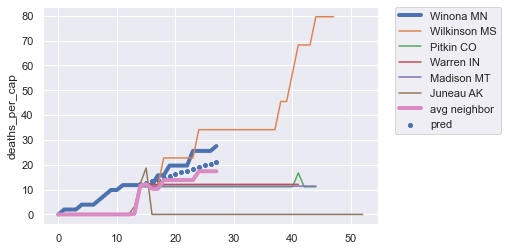

<Figure size 3000x2000 with 0 Axes>

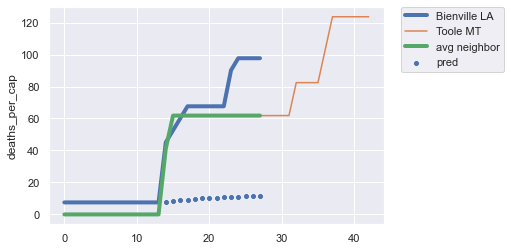

<Figure size 3000x2000 with 0 Axes>

no match found for county: Randolph


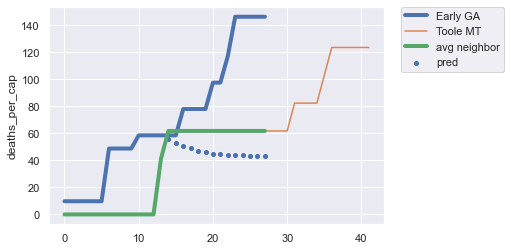

<Figure size 3000x2000 with 0 Axes>

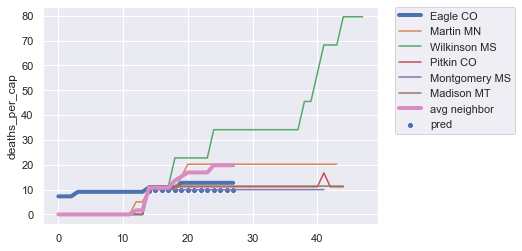

<Figure size 3000x2000 with 0 Axes>

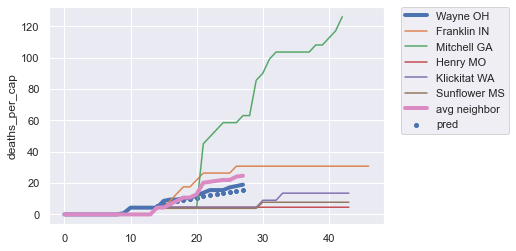

<Figure size 3000x2000 with 0 Axes>

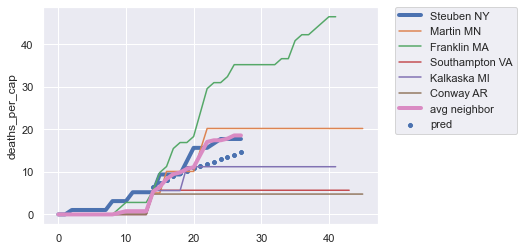

<Figure size 3000x2000 with 0 Axes>

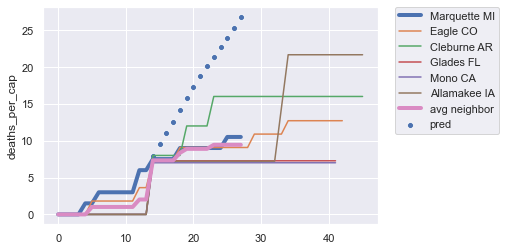

<Figure size 3000x2000 with 0 Axes>

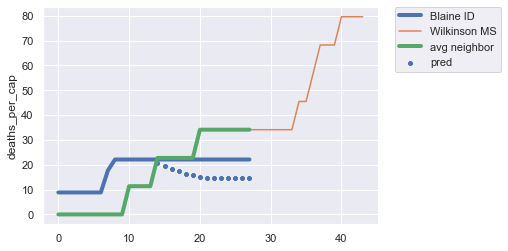

<Figure size 3000x2000 with 0 Axes>

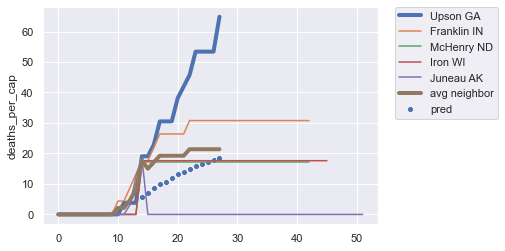

<Figure size 3000x2000 with 0 Axes>

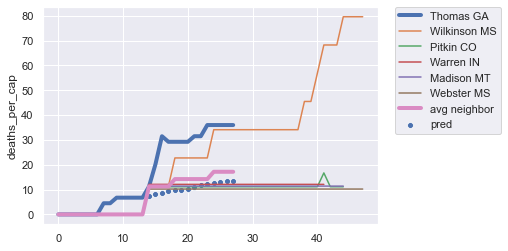

<Figure size 3000x2000 with 0 Axes>

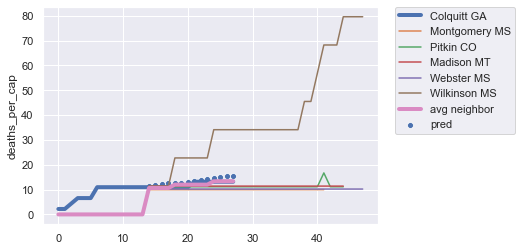

<Figure size 3000x2000 with 0 Axes>

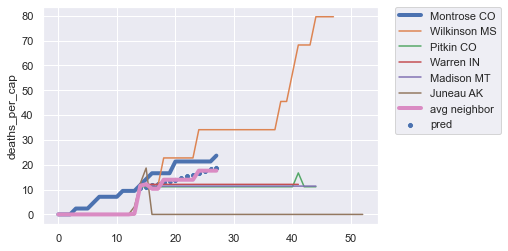

<Figure size 3000x2000 with 0 Axes>

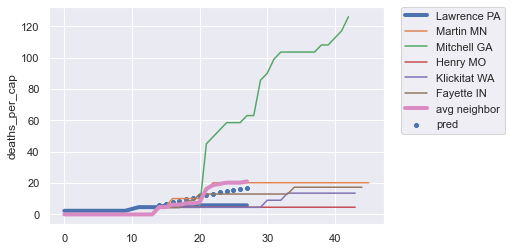

<Figure size 3000x2000 with 0 Axes>

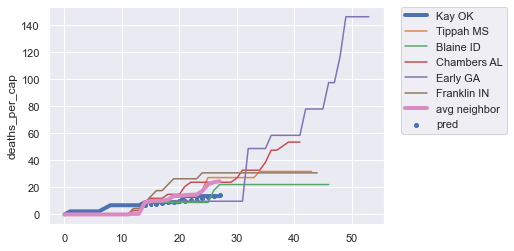

<Figure size 3000x2000 with 0 Axes>

no match found for county: Greer


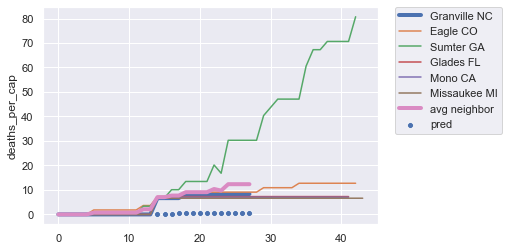

<Figure size 3000x2000 with 0 Axes>

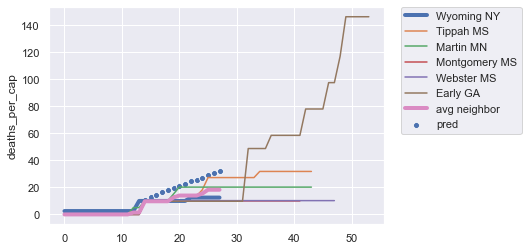

<Figure size 3000x2000 with 0 Axes>

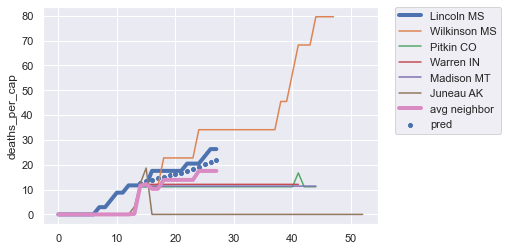

<Figure size 3000x2000 with 0 Axes>

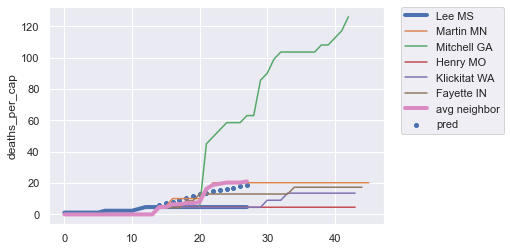

<Figure size 3000x2000 with 0 Axes>

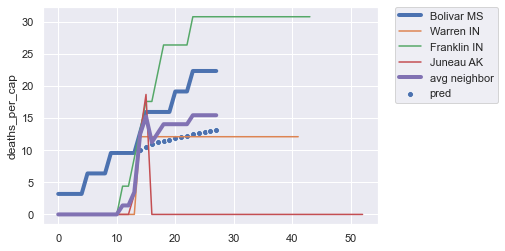

<Figure size 3000x2000 with 0 Axes>

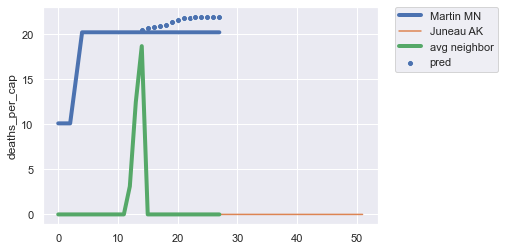

<Figure size 3000x2000 with 0 Axes>

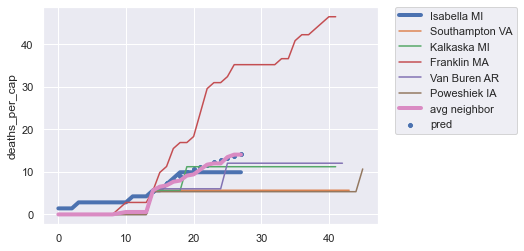

<Figure size 3000x2000 with 0 Axes>

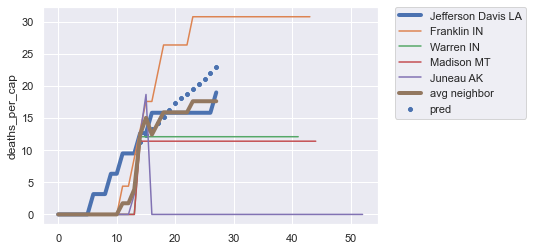

<Figure size 3000x2000 with 0 Axes>

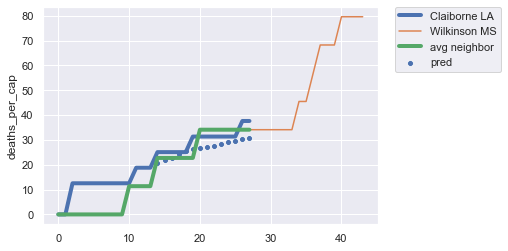

<Figure size 3000x2000 with 0 Axes>

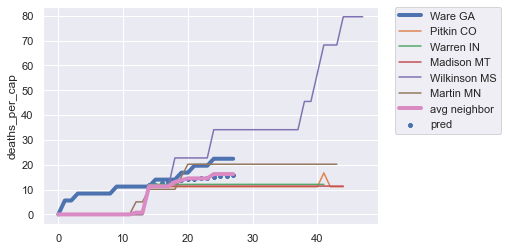

<Figure size 3000x2000 with 0 Axes>

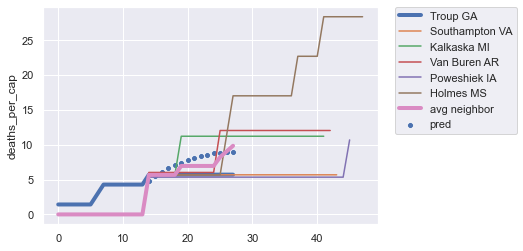

<Figure size 3000x2000 with 0 Axes>

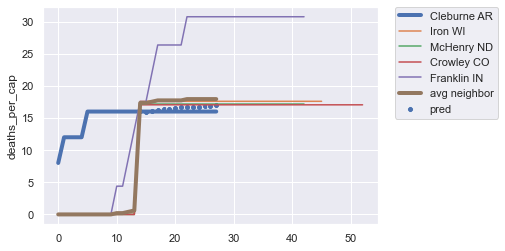

<Figure size 3000x2000 with 0 Axes>

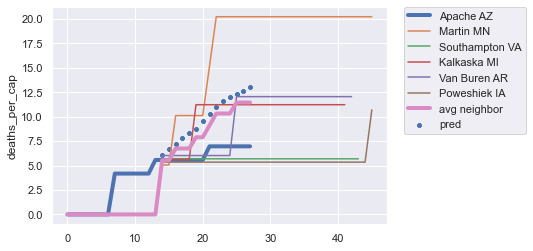

<Figure size 3000x2000 with 0 Axes>

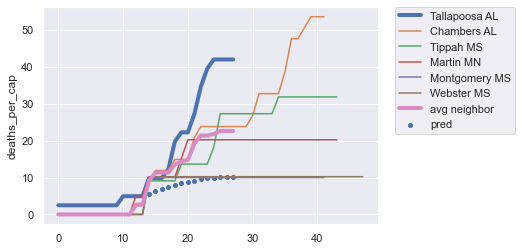

<Figure size 3000x2000 with 0 Axes>

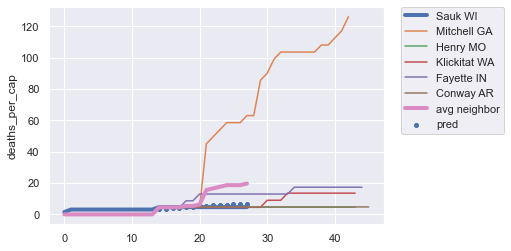

<Figure size 3000x2000 with 0 Axes>

no match found for county: Greensville


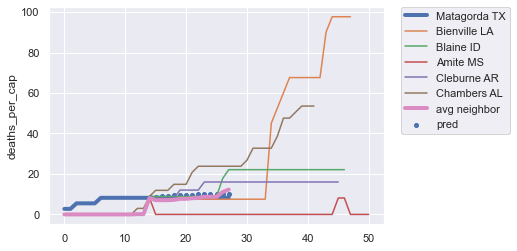

<Figure size 3000x2000 with 0 Axes>

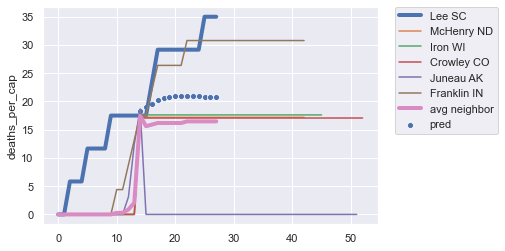

<Figure size 3000x2000 with 0 Axes>

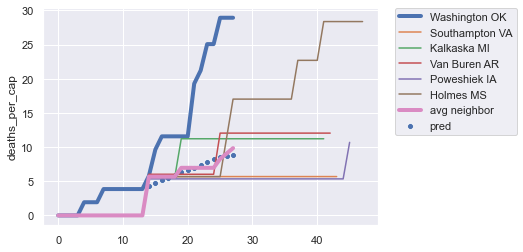

<Figure size 3000x2000 with 0 Axes>

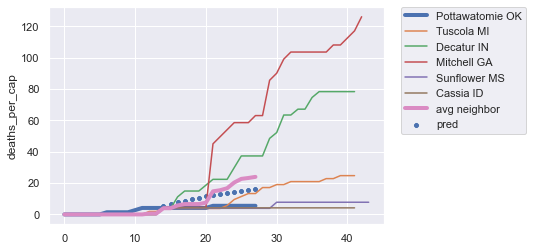

<Figure size 3000x2000 with 0 Axes>

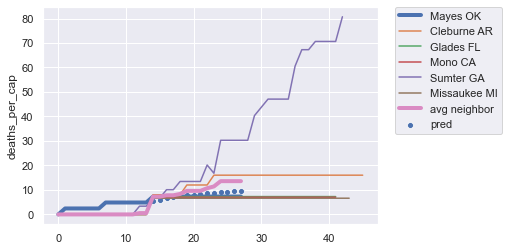

<Figure size 3000x2000 with 0 Axes>

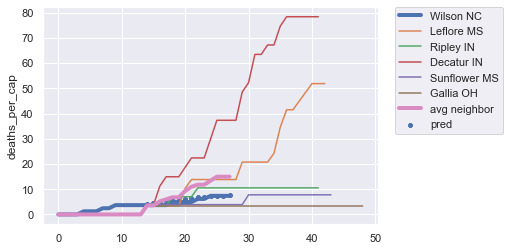

<Figure size 3000x2000 with 0 Axes>

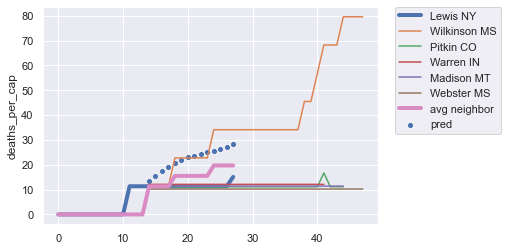

<Figure size 3000x2000 with 0 Axes>

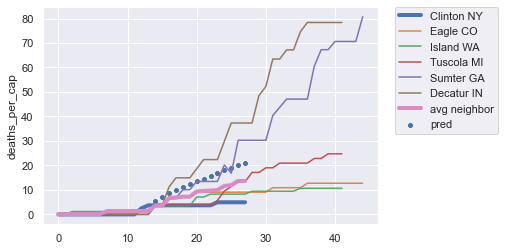

<Figure size 3000x2000 with 0 Axes>

no match found for county: Toole
no match found for county: Wilkinson


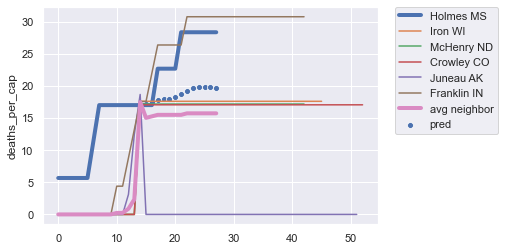

<Figure size 3000x2000 with 0 Axes>

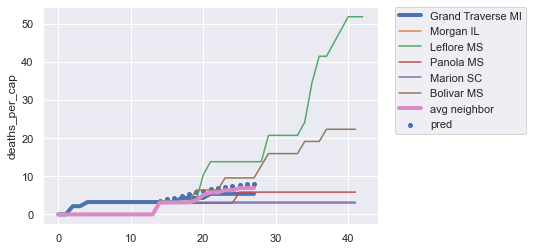

<Figure size 3000x2000 with 0 Axes>

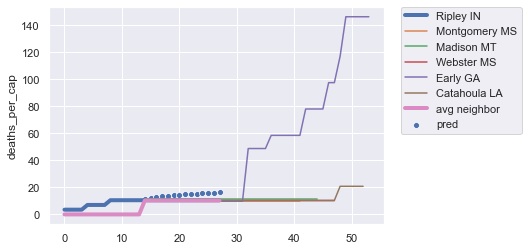

<Figure size 3000x2000 with 0 Axes>

no match found for county: Orange


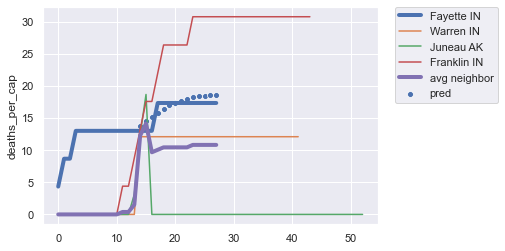

<Figure size 3000x2000 with 0 Axes>

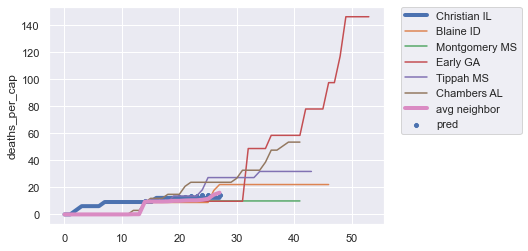

<Figure size 3000x2000 with 0 Axes>

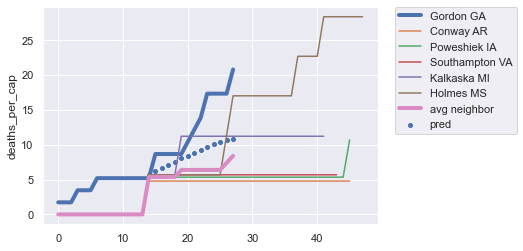

<Figure size 3000x2000 with 0 Axes>

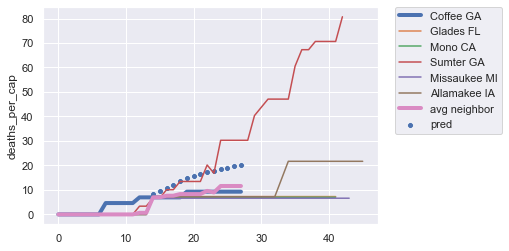

<Figure size 3000x2000 with 0 Axes>

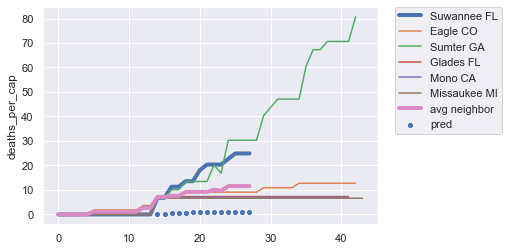

<Figure size 3000x2000 with 0 Axes>

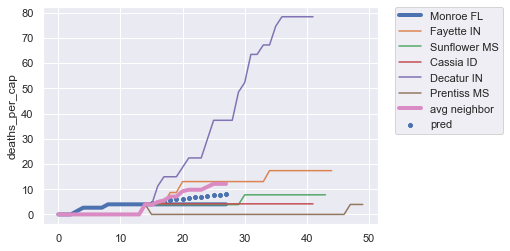

<Figure size 3000x2000 with 0 Axes>

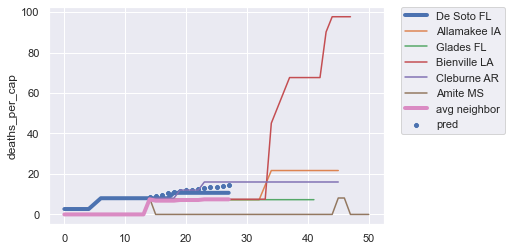

<Figure size 3000x2000 with 0 Axes>

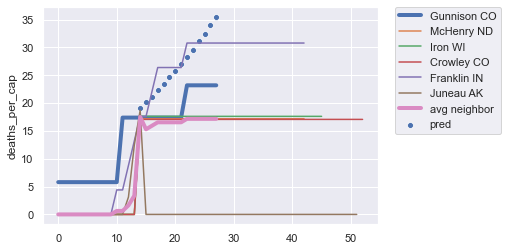

<Figure size 3000x2000 with 0 Axes>

total dif
6280.763114527372
pred dif
7179.240893920725


In [214]:
total_difs = 0
pred_difs = 0
for i in range(0,80):
    neigh_indices = [i] 

#     val_difs, pred_dif = plot_matched_counties(df,neigh_indices,time_dif=True)
    val_difs, pred_dif = plot_dynamic_matched_counties(df,neigh_indices,time_dif=True,plot_preds=True,weighted=True)
    
    if val_difs is not None:

        total_difs += val_difs
        pred_difs += pred_dif
    
print('total dif')
print(total_difs)
print('pred dif')
print(pred_difs)

In [31]:
rural_codes = list(df['Rural-UrbanContinuumCode2013'])
deaths = list(df['deaths'])
rural_counties = Counter({i:deaths[i][-14] for i in range(len(df)) if rural_codes[i] > 3})
rural_counties = [r[0] for r in rural_counties.most_common()]
